In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import seaborn as sns

In [4]:
sns.set_context('paper', font_scale=2.2)
sns.set_style('ticks')

In [17]:
import mako as m
import mako.template as mte
import mako.runtime as mrt
import StringIO as sio

In [18]:
import LB_colony_growth.LB_colony_growth as lb

In [19]:
dimension = 2

workgroup_x = 32
workgroup_y = 16

halo = 1 #ALWAYS 1 for this system.

num_alleles = 2

nx = 128
ny = 128

velocity_set = 'D2Q9'

In [21]:
bc_halo = 1
bc_map = np.zeros((nx + 2*bc_halo, ny + 2*bc_halo), dtype=lb.int_type)

bc_map[...] = lb.FLUID_NODE

bc_map[0:bc_halo, :] = lb.WALL_NODE
bc_map[-bc_halo:, :] = lb.WALL_NODE
bc_map[:, 0:bc_halo] = lb.WALL_NODE
bc_map[:, -bc_halo:] = lb.WALL_NODE

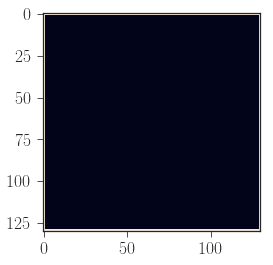

In [22]:
plt.imshow(bc_map)

In [12]:
ctx_info = {}
ctx_info['num_type'] = 'double'


ctx_info['nx'] = nx
ctx_info['ny'] = ny
ctx_info['nz'] = None

ctx_info['local_size'] = (workgroup_x, workgroup_y)
ctx_info['domain_size'] = (nx, ny)

ctx_info['dimension'] = dimension
ctx_info['num_alleles'] = num_alleles

ctx_info['kernel_arguments'] = {}

In [14]:
lb.DLA_Colony(ctx_info, 'D2Q9')

global size: (128, 128)
local size: (32, 16)
The platforms detected are:
---------------------------
Intel(R) OpenCL Intel(R) Corporation version: OpenCL 1.2 LINUX
The devices detected on platform Intel(R) OpenCL are:
---------------------------
       Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz [Type: CPU ]
Maximum clock Frequency: 2000 MHz
Maximum allocable memory size: 2062 MB
Maximum work group size 8192
Maximum work item dimensions 3
Maximum work item size [8192L, 8192L, 8192L]
---------------------------
This context is associated with  1 devices


LB_colony_growth/LB_colony_growth.py:470: UserWarning: Received OpenCL source code in Unicode, should be ASCII string. Attempting conversion.
  """


TypeError: long() argument must be a string or a number, not 'NoneType'

In [39]:
template = mte.Template(
    filename='./LB_colony_growth/colony_growth.mako',
    strict_undefined=True
)

In [40]:
buf = sio.StringIO()

context = mrt.Context(buf, **ctx_info)
template.render_context(context)

print buf.getvalue()

#ifdef cl_khr_fp64
    #pragma OPENCL EXTENSION cl_khr_fp64 : enable
#elif defined(cl_amd_fp64)
    #pragma OPENCL EXTENSION cl_amd_fp64 : enable
#else
    #error "Double precision floating point not supported by OpenCL implementation."
#endif

// Define domain size
#define nx 128
#define ny 128

#define SMALL 1e-6

#define NUM_NEAREST_NEIGHBORS 4
__constant int cx_nearest[4] = {1, -1, 0, 0};
__constant int cy_nearest[4] = {0,  0, 1,-1};

//The code is always ok, AS LONG as the halo is one! Regardless of the stencil.
// If any more, everything breaks.
#define halo 1

#define FLUID_NODE 0
#define WALL_NODE 1
#define NOT_IN_DOMAIN 2
//Alleles get negative numbers as identifiers
#define ALLELE_1 -1
#define ALLELE_2 -2

inline int get_spatial_index_2(
    const int x, const int y,
    const int x_size, const int y_size)
{
    return y*x_size + x;
}

inline int get_spatial_index_3(
    const int x, const int y, const int z,
    const int x_size, const int y_size, const int z_size)
{
    ret

In [29]:
ctx_info['kernel_arguments']

{'collide_and_propagate': [['bc_map',
   '__global __read_only int *bc_map_global'],
  ['num_jumpers', 'const int num_jumpers'],
  ['f', '__global double *f_global'],
  ['feq', '__global __read_only double *feq_global'],
  ['omega', 'const double omega'],
  ['c_vec', '__constant int *c_vec'],
  ['c_mag', '__constant double *c_mag'],
  ['w', '__constant double *w'],
  ['num_jumpers', 'const int num_jumpers'],
  ['rho', '__global double *rho_global'],
  ['buf_nx', 'const int buf_nx'],
  ['buf_ny', 'const int buf_ny'],
  ['buf_nz', 'const int buf_nz'],
  ['local_mem', '__local double *rho_local'],
  ['local_mem', '__local double *bc_map_local'],
  ['k', 'const double k'],
  ['D', 'const double D']],
 'reproduce': [],
 'update_after_streaming': []}